In [1]:
import os
import pickle
import datetime
import warnings

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from pyproj import CRS, Transformer

dir = "/mnt/d/csrs_2024/all"
toRun = ["la01"]
years = ["2016", "2017", "2018", "2019"]
interpolation_time = 15

In [2]:
import src.Catalog.Catalog as Catalog

dir = "./tests"
sta = "ExamplePos"
years = ["2010", "2011"]
interpolation_time = 15
cat = Catalog.Datastream(os.path.join(dir, sta), sta, years, interpolation_time)

./tests/ExamplePos
<class 'str'>
./tests/ExamplePos
<class 'str'>


/mnt/c/users/ZacharyKatz/Desktop/WhillansCatPaper/WhillansCatalogPaper/src/Catalog/Catalog.py:130: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, ind_data], ignore_index=True)


In [14]:
print(cat.data["time"].iloc[-1])

2011-01-01 23:59:45


In [1]:
# Zachary Katz
# zachary_katz@mines.edu
# 19 February 2024

"""
Catalog.ipynb creates the pickle files containing GPS_Data objects for each
station in list 'to_run' (see cell labeled # Main). Output pickle files are named
XXXX.pkl, where XXXX is the station name. Move output files to folder Pickle
for use in picking events (PickEvents.ipynb)

Requires processed gps .pos files in folders labeled with station name and year
at directory given by string 'dir' (see cell labeled # Main). This is currently
coded on the MGL_1 external hard drive, or D drive. 

Example Directory Tree:
--------------------------------------------------------------------------------
lissard
    ↳la01
        ↳2010
            ↳la010150.pos
             la010160.pos
            ...
        ↳2011
            ...
    ↳la02
        ...
--------------------------------------------------------------------------------

Precise point solution files are from Natural Resources Canada, Geodetic Survey 
Division, Geomatics Canada, and processed at several different times, resulting 
in several differences in how the data within a file is structured; these are 
handled by try except statements.

Version History
1.3 15 April 2024    | Updates to deal with stations with non-15 second increments.
                       These stations are indicated in the main cell.
1.2 19 February 2024 | Updated load to deal with 2024 CSRS-PPP for files with
                       dates startign 2018-01-01, which are back to forward order.
1.1 02 February 2024 | Updated load and datastream to proccess 2024 CSRS-PPP
                       processed files, which give dates in reverse order.
1.0 22 December 2023 | Initial Version

Notes For Zachary:
- Run with gps python kernel
- See notes in # Main cell regarding what data has not been fully extracted to a
pickle file.
"""


# Class containing info to be stored
class GPS_data:
    def __init__(self, starts, ends, gaps, data, name, increment):
        self.increment = increment
        self.starts = starts
        self.ends = ends
        self.gaps = gaps
        self.data = data
        self.name = name

In [2]:
def ll2xy(lon, lat):
    """
    Transform coordinates from input geodetic coordinates (lon, lat)
    to output Antarctic Polar Stereographic coordinates (x, y)

    Parameters
    lon - Geodetic longitude in EPSG:4326 [float]
    lat - Geodetic latitude in EPSG:4326 [float]

    Returns
    x - Antarctic Polar Stereographic (EPSG:3031) x [float]
    y - Antarctic Polar Stereographic (EPSG:3031) y [float]
    """

    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy=True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

In [3]:
def load(file):
    """
    Load processed gps data file into pandas table.

    Parameters
    file - .pos precise point solution file, Natural Resources Canada [string]

    Returns
    data - Pandas DataFrame with the following columns, extracted from file
        longitude - Geodetic longitude
        latitude - Geodetic latitude
        elevation - Elevation
        time - Time as datetime object
        day_of_year - Time as julian day
        x - Antarctic Polar Stereographic x
        y - Antarctic Polar Stereographic y
        dist - Euclidian distance from starting position in meters
    flip - flag to flip order of readings for 2024 csrs-ppp data
    """

    data = pd.DataFrame()  # Create Pandas DataFrame
    flip = False
    # Read data file

    # Convert longitude and latitude from deg min sec to fractional degrees
    # Three different file formats so try one first and try the other if it
    # throws a not found exception.
    try:
        # CSRS-PPP 2024
        d = pd.read_csv(file, skiprows=3, delim_whitespace=True)
        # Only take 15 or 30 sec intervals if data is finer spaced
        d = d.loc[
            d["HR:MN:SS.SS"].str.endswith("00.00")
            | d["HR:MN:SS.SS"].str.endswith("15.00")
            | d["HR:MN:SS.SS"].str.endswith("30.00")
            | d["HR:MN:SS.SS"].str.endswith("45.00")
        ]
        data["longitude"] = d["LONDD"] - d["LONMN"] / 60 - d["LONSS"] / 60 / 60
        data["latitude"] = d["LATDD"] - d["LATMN"] / 60 - d["LATSS"] / 60 / 60
        data["time"] = pd.to_datetime(d["YEAR-MM-DD"] + "T" + d["HR:MN:SS.SS"])
        data["day_of_year"] = d["DAYofYEAR"]

        # Look at data and decide if to flip
        if len(data.index) > 1:
            diff = data["time"].iloc[0] - data["time"].iloc[1]
            if diff > datetime.timedelta(seconds=0):
                flip = True
        # print(file,data['time'].iloc[0],data['time'].iloc[0],diff,flip)
        # if data['time'].iloc[0] < datetime.datetime(2018,1,1):
        #    flip = True
    except Exception as e:
        try:
            print(e)
            d = pd.read_csv(file, skiprows=7, delim_whitespace=True)
            data["longitude"] = d["LON(d)"] - d["LON(m)"] / 60 - d["LON(s)"] / 60 / 60
            data["latitude"] = d["LAT(d)"] - d["LAT(m)"] / 60 - d["LAT(s)"] / 60 / 60
            data["time"] = pd.to_datetime(d["YEAR-MM-DD"] + "T" + d["HR:MN:SS.SSS"])
            data["day_of_year"] = d["DOY"]
        except Exception as e:
            try:
                print(e)
                d = pd.read_csv(file, skiprows=5, delim_whitespace=True)
                data["longitude"] = d["LONDD"] - d["LONMN"] / 60 - d["LONSS"] / 60 / 60
                data["latitude"] = d["LATDD"] - d["LATMN"] / 60 - d["LATSS"] / 60 / 60
                data["time"] = pd.to_datetime(d["YEAR-MM-DD"] + "T" + d["HR:MN:SS.SS"])
                data["day_of_year"] = d["DAYofYEAR"]
            except Exception as e:
                print(e)
                d = pd.read_csv(file, skiprows=6, delim_whitespace=True)
                data["longitude"] = (
                    d["LON(d)"] - d["LON(m)"] / 60 - d["LON(s)"] / 60 / 60
                )
                data["latitude"] = (
                    d["LAT(d)"] - d["LAT(m)"] / 60 - d["LAT(s)"] / 60 / 60
                )
                data["time"] = pd.to_datetime(d["YEAR-MM-DD"] + "T" + d["HR:MN:SS.SSS"])
                data["day_of_year"] = d["DOY"]

    data["elevation"] = d["HGT(m)"]
    data["sats"] = d["NSV"]
    data["GDOP"] = d["GDOP"]

    # Convert to Antarctic Polar Stereographic
    x, y = ll2xy(lon=data["longitude"], lat=data["latitude"])
    data["x"] = x
    data["y"] = y

    x0 = data["x"].iloc[0]
    y0 = data["y"].iloc[0]

    data["dist"] = np.sqrt((data["x"] - x0) ** 2 + (data["y"] - y0) ** 2)

    return data, flip

In [4]:
def datastream(dir, years):
    """
    Takes input directory dir with year subdirectories containign .pos files.
    Starting from the first file in the first year, append days until all files
    in the directory have been added.

    Parameters
    dir - Input directory tree with structure described in top comment [string]
    years - years to be run [arr of strings]

    Returns
    data - Resulting multiday time series, data. [DataFrame]
    """
    data = pd.DataFrame()
    for year in years:
        for folder in os.scandir(dir.path):
            if folder.is_dir():  # folder is an os.DirEntry object
                if folder.name == year:
                    print(folder.name)
                    for gps in sorted(os.listdir(folder.path)):
                        if gps.endswith(".pos") and not gps.startswith(
                            "."
                        ):  # Ignore xyzt, zip files
                            # print(gps)
                            ind_data, flip = load(folder.path + "/" + gps)
                            if flip:  # Reorder the data if using CSRS-PPP 2024 pre 2018
                                ind_data = ind_data.reindex(index=ind_data.index[::-1])
                            data = pd.concat([data, ind_data], ignore_index=True)
    return data

In [5]:
def interpolate(data, prior_date, date, gap, i, interpolate_elements):
    """
    Interpolate the given data gap using Pandas' linear interpolation scheme.

    Input Parametrers
        data - PandasDataframe with time gaps [DataFrame]
        prior_data - last time entry before data gap [Datetime]
        date - first time entry after data gap [Datetime]
        gap - length of gap in seconds [Timedelta]
        i - DataFrame row index of first entry after data gap [integer]
        interpolate_elements - number of elements needed to be interpolated [integer]

    Returns
        data - interpolated DataFrame [DataFrame]
    """

    # Loop over each missing row
    for row in range(interpolate_elements - 1):
        # Make dataframe row
        insert = pd.DataFrame(columns=data.columns, index=[i + row])
        with warnings.catch_warnings():
            warnings.simplefilter(action="ignore", category=FutureWarning)
            data = pd.concat(
                [data.iloc[: i + row], insert, data.iloc[i + row :]]
            ).reset_index(drop=True)
    data = data.interpolate(method="linear")  # Built-in pandas function
    return data

In [6]:
def findgaps(data, gap_len):
    """
    Finds gaps in a dataframe loaded with datastream. Returns interpolated data
    and two arrays corresponding to the start entry and the length of the gap

    Input Paramerers
        data - DataFrame with or without gaps to interpolate [DataFrame]
        gap_len - the length of time of the base data
    Returns
        data - DataFrame that has been interpolated [DataFrame]
        starts - list of start times of uninterpolated data gaps (because they
                were too long to interpolate) [Array of Datetimes]
        ends - list of end times of uninterpolated data gaps (because they
                were too long to interpolate) [Array of Datetimes]
        gaps - list of lengths in seconds of uninterpolated data gaps (because
                they were too long to interpolate) [Array of Timedeltas]
    """

    starts = []  # First Data point after gap
    ends = []  # Last data point before gap
    gaps = []  # Length of data [Start time - End time]

    # Time (in seconds, inclusive) to allow interpolation before shutting off
    interpolate_time = 120
    starts.append(data["time"].iloc[0])
    for i in data.index:
        # Check not first element
        if i > 0:
            prior_date = data["time"][i - 1]
            date = data["time"][i]

            # Check if time between dates is not less than 16 seconds
            # Choose 16 to catch weird 15 second gaps like 15.00003
            gaptime = gap_len + 1
            if date - prior_date > datetime.timedelta(seconds=gaptime):
                gap = date - prior_date
                # print(date,prior_date, i, gap)

                # If gap interpolatable, call interpolate and add to df else
                # note gap start, end, and length then continue.
                if gap <= datetime.timedelta(seconds=interpolate_time):
                    # Find number of elements needed to be interpolated, using
                    # gap length // 15 seconds,
                    interpolate_elements = int(gap.total_seconds() // gap_len)
                    print(prior_date, date, gap, i)
                    data = interpolate(
                        data, prior_date, date, gap, i, interpolate_elements
                    )
                else:
                    starts.append(date)
                    ends.append(prior_date)
                    gaps.append(gap)
    ends.append(data["time"].iloc[-1])
    return data, starts, ends, gaps

In [8]:
dir = "/mnt/c"

# dir = '/mnt/d/data/gps/proc/csrs/lissard'
# dir = '/mnt/d/data/gps/proc/csrs/rages'

##############################
##### CHANGE DIRECTORY #######

# Loop over all stations
for sta in os.scandir(dir):
    print(type(sta))

<class 'posix.DirEntry'>
<class 'posix.DirEntry'>
<class 'posix.DirEntry'>
<class 'posix.DirEntry'>
<class 'posix.DirEntry'>
<class 'posix.DirEntry'>
<class 'posix.DirEntry'>
<class 'posix.DirEntry'>
<class 'posix.DirEntry'>
<class 'posix.DirEntry'>
<class 'posix.DirEntry'>
<class 'posix.DirEntry'>
<class 'posix.DirEntry'>
<class 'posix.DirEntry'>
<class 'posix.DirEntry'>
<class 'posix.DirEntry'>
<class 'posix.DirEntry'>
<class 'posix.DirEntry'>
<class 'posix.DirEntry'>
<class 'posix.DirEntry'>
<class 'posix.DirEntry'>
<class 'posix.DirEntry'>
<class 'posix.DirEntry'>
<class 'posix.DirEntry'>
<class 'posix.DirEntry'>


In [8]:
# Main

# This cell takes several minutes to run, depending on how many stations and the
# amount of data at each station. Extracts and interpolates the data, then saves
# to a pickle file

##### CHANGE DIRECTORY #######
##############################

# dir = '/mnt/d/csrs_2024/lissard'
# dir = '/mnt/d/csrs_2024/rages'
# dir = '/mnt/d/csrs_2024/combined'
dir = "/mnt/d/csrs_2024/all"

# dir = '/mnt/d/data/gps/proc/csrs/lissard'
# dir = '/mnt/d/data/gps/proc/csrs/rages'

##############################
##### CHANGE DIRECTORY #######

# Loop over all stations
for sta in os.scandir(dir):
    if sta.is_dir():
        # List of Stations with data not in 15 sec increments
        # la02 | 2008 - 7 JAN 2014 (la020070) 30 sec
        # slw1 | 2009 - 2010 02 sec Currently Ignored in processing

        # la14 | 2017? 30 sec
        # la09 | 2010 - 5 FEB 2010 (la090310) 30 sec

        # whl02,03,07,09,11 only in xyzt format and no rinex

        # OLD NOTES
        # la02 Starts with 30 sec increments, later has 01 second increments.
        # la09 30 second increments for first 17 days
        # la14 30 second increments where?
        # whl02,03,07,09,11 only in xyzt format
        # slw1 30 second increments in 2010, 2

        # Must manually Change toRun and years
        ##### CHANGE STATIONS AND YEAR  #######
        #######################################

        # Doesn't include slw1, la02, whlXX
        # 'la08', 'gz19', 'la16', 'mg04'
        toRun = [
            "la01",
            "la02",
            "la03",
            "la04",
            "la05",
            "la06",
            "la07",
            "la09",
            "la10",
            "la11",
            "la12",
            "la13",
            "la14",
            "la15",
            "ws04",
            "ws05",
            "gz01",
            "gz02",
            "gz03",
            "gz04",
            "gz05",
            "gz06",
            "gz07",
            "gz08",
            "gz09",
            "gz10",
            "gz11",
            "gz12",
            "gz13",
            "gz14",
            "gz15",
            "gz16",
            "gz17",
            "gz18",
            "mg01",
            "mg02",
            "mg03",
            "mg05",
            "mg06",
            "mg07",
        ]

        # toRun = ['gz01','gz02','gz03','gz04','gz05','gz06','gz07','gz08','gz09','gz10','gz11','gz12','gz13','gz14', \
        #    'gz15','gz16','gz17','gz18','gz19','mg01','mg02','mg03','mg04','mg05','mg06','mg07']
        # toRun = ['mt04','ww01','ww02','ww03','ww04','ww05','ww06','ww07','ww08','ww09','ww10','ww11']
        # toRun = ['la01','la03','la04','la05','la06','la07','la08','la10','la11','la12','la13','la14','la15','la16', \
        #   'la17','la18', 'ws04','ws05']
        # toRun= ['gz20','la02','la09','la14','la17','la18']

        toRun = ["la14"]

        interpolation_time = 15

        years = ["2016", "2017", "2018", "2019"]
        yearstr = "2016_2019"

        ######################################
        ##### CHANGE STATIONS AND YEAR #######
        # print(sta.name)
        if sta.name in toRun:
            print(sta.name, sta.path)
            stream = datastream(sta, years)  # Load data
            if (
                not stream.empty
            ):  # Pass if no data for that station during years selected
                stream = stream.sort_values(by="time")  # Ensure sorted
                interpolated, starts, ends, gaps = findgaps(
                    stream, interpolation_time
                )  # Interpolate Data
                obj = GPS_data(
                    starts, ends, gaps, interpolated, sta.name, interpolation_time
                )  # Make Object
                with open(
                    yearstr + sta.name + ".pkl", "wb"
                ) as file:  # Save to Pickle File
                    pickle.dump(obj, file)

/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 13:56:15 2018-10-12 13:57:45 0 days 00:01:30 1714570


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 13:58:00 2018-10-12 13:59:45 0 days 00:01:45 1714577


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 13:59:45 2018-10-12 14:01:15 0 days 00:01:30 1714584


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:01:30 2018-10-12 14:03:00 0 days 00:01:30 1714591


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:03:15 2018-10-12 14:04:30 0 days 00:01:15 1714598


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:04:45 2018-10-12 14:06:15 0 days 00:01:30 1714604


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:06:30 2018-10-12 14:08:00 0 days 00:01:30 1714611


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:08:00 2018-10-12 14:09:30 0 days 00:01:30 1714617


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:09:45 2018-10-12 14:11:15 0 days 00:01:30 1714624


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:11:15 2018-10-12 14:12:45 0 days 00:01:30 1714630


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:13:00 2018-10-12 14:14:30 0 days 00:01:30 1714637


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:14:30 2018-10-12 14:16:00 0 days 00:01:30 1714643


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:16:15 2018-10-12 14:17:45 0 days 00:01:30 1714650


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:17:45 2018-10-12 14:19:15 0 days 00:01:30 1714656


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:19:30 2018-10-12 14:21:00 0 days 00:01:30 1714663


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:21:00 2018-10-12 14:22:30 0 days 00:01:30 1714669


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:22:45 2018-10-12 14:24:15 0 days 00:01:30 1714676


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:24:15 2018-10-12 14:25:45 0 days 00:01:30 1714682


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:26:00 2018-10-12 14:27:15 0 days 00:01:15 1714689


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:27:30 2018-10-12 14:29:00 0 days 00:01:30 1714695


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:29:00 2018-10-12 14:30:30 0 days 00:01:30 1714701


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:30:30 2018-10-12 14:32:00 0 days 00:01:30 1714707


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:32:15 2018-10-12 14:33:30 0 days 00:01:15 1714714


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:33:45 2018-10-12 14:35:15 0 days 00:01:30 1714720


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:35:15 2018-10-12 14:36:30 0 days 00:01:15 1714726


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:36:45 2018-10-12 14:38:00 0 days 00:01:15 1714732


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:38:15 2018-10-12 14:39:45 0 days 00:01:30 1714738


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:39:45 2018-10-12 14:41:00 0 days 00:01:15 1714744


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:41:15 2018-10-12 14:42:30 0 days 00:01:15 1714750


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:42:45 2018-10-12 14:44:00 0 days 00:01:15 1714756


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:44:15 2018-10-12 14:45:45 0 days 00:01:30 1714762


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:45:45 2018-10-12 14:47:15 0 days 00:01:30 1714768


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:47:15 2018-10-12 14:48:45 0 days 00:01:30 1714774


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:48:45 2018-10-12 14:50:15 0 days 00:01:30 1714780


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:50:30 2018-10-12 14:51:45 0 days 00:01:15 1714787


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:52:00 2018-10-12 14:53:15 0 days 00:01:15 1714793


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:53:30 2018-10-12 14:55:00 0 days 00:01:30 1714799


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:55:00 2018-10-12 14:56:30 0 days 00:01:30 1714805


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:56:45 2018-10-12 14:58:15 0 days 00:01:30 1714812


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 14:58:15 2018-10-12 15:00:00 0 days 00:01:45 1714818


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 15:00:00 2018-10-12 15:01:15 0 days 00:01:15 1714825


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 15:01:30 2018-10-12 15:03:00 0 days 00:01:30 1714831


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 15:03:00 2018-10-12 15:04:30 0 days 00:01:30 1714837


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 15:04:30 2018-10-12 15:06:00 0 days 00:01:30 1714843


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 15:06:00 2018-10-12 15:07:15 0 days 00:01:15 1714849


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 15:07:30 2018-10-12 15:08:45 0 days 00:01:15 1714855


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 15:08:45 2018-10-12 15:10:00 0 days 00:01:15 1714860


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 15:10:15 2018-10-12 15:11:30 0 days 00:01:15 1714866


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 15:11:30 2018-10-12 15:12:45 0 days 00:01:15 1714871


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 15:13:00 2018-10-12 15:14:15 0 days 00:01:15 1714877


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 15:14:15 2018-10-12 15:15:30 0 days 00:01:15 1714882


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 15:15:45 2018-10-12 15:16:45 0 days 00:01:00 1714888


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 15:17:00 2018-10-12 15:18:00 0 days 00:01:00 1714893


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 15:18:15 2018-10-12 15:19:30 0 days 00:01:15 1714898


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 15:19:30 2018-10-12 15:20:45 0 days 00:01:15 1714903


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 15:21:00 2018-10-12 15:22:00 0 days 00:01:00 1714909


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 15:22:15 2018-10-12 15:23:30 0 days 00:01:15 1714914


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-12 15:24:30 2018-10-12 15:25:45 0 days 00:01:15 1714923


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 12:55:45 2018-10-13 12:57:45 0 days 00:02:00 1720000


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 13:00:30 2018-10-13 13:02:30 0 days 00:02:00 1720011


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 13:09:45 2018-10-13 13:11:45 0 days 00:02:00 1720024


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 13:12:00 2018-10-13 13:14:00 0 days 00:02:00 1720033


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 13:28:15 2018-10-13 13:30:15 0 days 00:02:00 1720050


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 13:30:30 2018-10-13 13:32:30 0 days 00:02:00 1720059


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 13:35:00 2018-10-13 13:37:00 0 days 00:02:00 1720069


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 13:37:00 2018-10-13 13:39:00 0 days 00:02:00 1720077


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 13:39:15 2018-10-13 13:40:45 0 days 00:01:30 1720086


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 13:41:00 2018-10-13 13:42:30 0 days 00:01:30 1720093


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 13:42:30 2018-10-13 13:43:45 0 days 00:01:15 1720099


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 13:44:00 2018-10-13 13:45:15 0 days 00:01:15 1720105


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 13:45:15 2018-10-13 13:46:30 0 days 00:01:15 1720110


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 13:46:45 2018-10-13 13:48:00 0 days 00:01:15 1720116


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 13:48:15 2018-10-13 13:49:30 0 days 00:01:15 1720122


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 13:49:30 2018-10-13 13:50:45 0 days 00:01:15 1720127


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 13:51:00 2018-10-13 13:52:00 0 days 00:01:00 1720133


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 13:52:15 2018-10-13 13:53:15 0 days 00:01:00 1720138


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 13:53:15 2018-10-13 13:54:30 0 days 00:01:15 1720142


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 13:54:30 2018-10-13 13:55:45 0 days 00:01:15 1720147


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 13:55:45 2018-10-13 13:57:00 0 days 00:01:15 1720152


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 13:57:15 2018-10-13 13:58:30 0 days 00:01:15 1720158


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 13:58:30 2018-10-13 13:59:45 0 days 00:01:15 1720163


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 13:59:45 2018-10-13 14:00:45 0 days 00:01:00 1720168


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 14:01:00 2018-10-13 14:02:00 0 days 00:01:00 1720173


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 14:02:15 2018-10-13 14:03:15 0 days 00:01:00 1720178


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 14:03:30 2018-10-13 14:04:45 0 days 00:01:15 1720183


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 14:04:45 2018-10-13 14:06:00 0 days 00:01:15 1720188


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 14:06:15 2018-10-13 14:07:15 0 days 00:01:00 1720194


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 14:07:30 2018-10-13 14:08:45 0 days 00:01:15 1720199


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 14:09:00 2018-10-13 14:10:00 0 days 00:01:00 1720205


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 14:10:15 2018-10-13 14:11:30 0 days 00:01:15 1720210


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 14:11:30 2018-10-13 14:12:45 0 days 00:01:15 1720215


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 14:13:00 2018-10-13 14:14:00 0 days 00:01:00 1720221


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 14:14:15 2018-10-13 14:15:30 0 days 00:01:15 1720226


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 14:15:30 2018-10-13 14:16:30 0 days 00:01:00 1720231


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 14:16:45 2018-10-13 14:17:45 0 days 00:01:00 1720236


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


2018-10-13 14:17:45 2018-10-13 14:19:00 0 days 00:01:15 1720240


/tmp/ipykernel_103890/3313739054.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate(method='linear') #Built-in pandas function


In [11]:
# Example load of saved pickle file
with open(
    "../../../Research/Catalog/Pickle2013_2014/2013_2014gz18.pkl", "rb"
) as file:  # Load Pickle File
    data = pickle.load(file)
# print(data.data[:600000])
print(data)
tes = data.data.sort_values(by="time")
print(tes)

FileNotFoundError: [Errno 2] No such file or directory: '../../../Research/Catalog/Pickle2013_2014/2013_2014gz18.pkl'

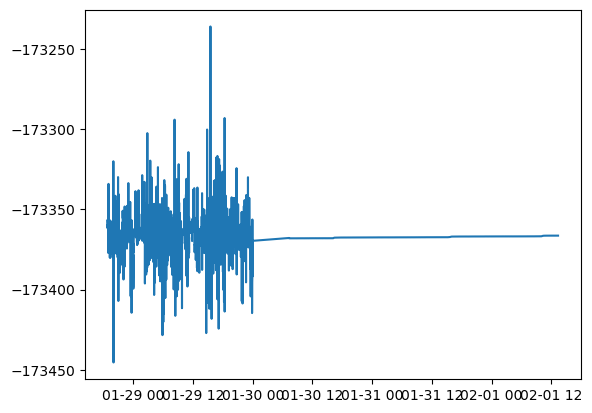

In [56]:
s = 160000
e = 180000
plt.plot(data.data["time"][s:e], data.data["x"][s:e])